# OnDeck Data Challenge
- Author: Chris Shih

## Table of Contents
### Part 1: Deduping
 - [Import the businesses.csv dataset and quickly look at the dataset](#Deduping)
 - [First Deduping Approach (using only Business Name)](#first_deduping)
 - [Second Deduping Approach (using Business Name & Postal Code)](#second_deduping)
 - [Potential Next Steps / Create CSV Pairs file](#next_steps)

### Part 2: Measuring Results
 - [Revenue Reconciliation of Duplicate Records](#part_2)
 - [Import Email Dataset](#email_dataset) 
 - [Analysis of Messages by Month](#messages_by_month) 
 - [Analysis of Revenue vs. Response Rate](#revenue) 
 - [Methodology / Takeaways](#methodology) 

### Conclusion
 - [Conclusions/Next Steps](#conclusion) 

<a id='Deduping'></a>
# Part 1: Deduping

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

In [3]:
businesses = pd.read_csv('businesses.csv')

## Quickly look at some of the businesses dataset

In [4]:
businesses.head()

,id,business_name,street_number,postal_code,phone,revenue,age_of_business
0,55234,HONOLULU AUTOWORKS,NaN,76259,3.372111e+09,1006893.0,3.0
1,31921,EMETEORS INC,NaN,49483,2.406784e+09,564444.0,12.0
2,19711,7-Eleven,NaN,64448,8.329000e+09,129895.0,25.0
3,53575,HILLTOP MAINTENANCE,NaN,87662,1.052236e+09,320152.0,1.0
4,38480,GAP,NaN,80456,6.580070e+09,230956.0,NaN


In [5]:
businesses.groupby('business_name').size().head(10)

business_name
#1 KARATE FOR KIDS FAMILY CENTER INC    2
(DIV. OF PROBE-RITE, CORP.)             1
007 LOCKSMITH                           1
1 24 7 PEST CONTROL                     1
1 GARAGE DOOR REPAIR                    1
1 HR T-SHIRTS TEAM UNIFORM              1
1 Hr T-Shirts Team Uniform              1
1 STOP PARTS AUTO SALVAGE INC           2
1-800-DRYCLEAN                          1
10 75 EMERGENCY LIGHTING L L C          1
dtype: int64

In [6]:
businesses[businesses['business_name']=='#1 KARATE FOR KIDS FAMILY CENTER INC']

,id,business_name,street_number,postal_code,phone,revenue,age_of_business
14562,78029,#1 KARATE FOR KIDS FAMILY CENTER INC,NaN,00382,2.507675e+09,185101.0,15.0
23476,69500,#1 KARATE FOR KIDS FAMILY CENTER INC,NaN,00382,2.507675e+09,140947.0,NaN


- After quick visual inspection it seems as if several duplicates either have the **same business name** or are the **same and capitalized**
- There are also several business names that were [NOT PROVIDED] and should likely be either removed or analyzed separately (in Part II)  

---

<a id='first_deduping'></a>
## First Deduping Approach  
1. **Create a "uniform" format** for business names (i.e. all lowercase letters and remove llc/co/inc)
2. **Identify** the unique business names in the dataset
3. **Link** each unqiue business name with its matching IDs

### Create a function to clean business names  
- Convert all business names to lowercase
- Remove leading/trailing non-alphanumeric characters
- Use regluar expressions to remove llc, l l c, inc, co, appostrophes, periods, commas , or slashes
- Strip extra spaces


In [7]:
import re

def clean(name):
    # change all business names to lowercase
    nm = name.lower()
    
    # remove leading non-alphanumeric characters
    # this assumes that businesses are not differentiated by leading punctuation
    i = 0
    for c in nm:
        if not c.isalnum():
            i+=1
            continue
        nm = nm[i:]
        break
        
    # same thing for trailing non-alphanumeric characters
    i = 0
    temp_str = nm[::-1]
    for c in temp_str:
        if not c.isalnum():
            i+=1
            continue
        nm = temp_str[i:][::-1]
        break

    # remove llc, inc, co, apostrophes
    # this might group companies differentiated by llc vs. inc
    # however, it seems more likely that companies simply forget to write llc, inc, co
    replace_patterns = [r'\'',r'\.',r'\,',r'/',r' llc\b',r' l l c\b',r' inc\b',r' co\b']
    for i in replace_patterns:
        nm = re.sub(i,'',nm)
    
    #strip spaces
    nm = nm.strip()
    
    return nm

In [8]:
# create dictionary of "cleaned" business names and their corresponding IDs

from collections import defaultdict
import csv

dupe_list = defaultdict(list)

with open('businesses.csv') as fhand:
    reader = csv.reader(fhand, delimiter=',', quotechar='\"')
    header_line = next(reader)
    for data in reader:
        bus_nm = clean(data[1])
        dupe_list[bus_nm].append(int(data[0].strip()))


In [9]:
# prepare to view output of dupe code
# sort dupes by business name and by number of IDs
dupes = []
dupe_sum = []

for k,v in dupe_list.items():
    dupes.append(str(k)+'|'+str(v))
    dupe_sum.append([len(v),str(k)])

### Check Initial Deduping
Order cleaned business names and look for any obvious duplicates missed

In [10]:
dupes.sort()
i = 0
for d in dupes:
    if i >= 15: break
    print(d)
    i+=1

007 locksmith|[30551]
1 24 7 pest control|[48006]
1 garage door repair|[11558]
1 hr t-shirts team uniform|[66900, 58154]
1 karate for kids family center|[78029, 69500]
1 stop parts auto salvage|[52603, 22845]
1-800-dryclean|[95094]
10 75 emergency lighting|[37251, 72076]
10 key accounting & fncl svc|[15030, 60218]
100 west hair studio|[91712]
1004 waterloo|[89360]
101 mower mart|[71546, 67330]
1022 south shady grove|[35638]
1068 curry rd|[23614, 93950]
115 truck stop|[33637, 62021]


### Note:
Check out a few examples, incorporating the rest of the data we have about the businesses

In [11]:
businesses[businesses['id'].isin(dupe_list['tuffy auto svc ctr'])]

,id,business_name,street_number,postal_code,phone,revenue,age_of_business
2072,95881,Tuffy Auto Svc Ctr Llc,3760.0,87810,NaN,797500.0,14.0
10267,43060,TUFFY AUTO SVC CTR,NaN,01642,NaN,179462.0,14.0
17012,40650,TUFFY AUTO SVC CTR,NaN,87810,NaN,666968.0,NaN
22245,96061,Tuffy Auto Svc Ctr Inc,NaN,01642,2.268492e+09,217223.0,9.0


In [12]:
businesses[businesses['id'].isin(dupe_list['zoup fresh soup company'])]

,id,business_name,street_number,postal_code,phone,revenue,age_of_business
2642,55310,ZOUP FRESH SOUP COMPANY,NaN,82408,NaN,910428.0,2.0
29789,98904,ZOUP FRESH SOUP COMPANY,NaN,82408,NaN,NaN,NaN


In [13]:
businesses[businesses['id'].isin(dupe_list['1 hr t-shirts team uniform'])]

,id,business_name,street_number,postal_code,phone,revenue,age_of_business
1192,66900,1 Hr T-Shirts Team Uniform,NaN,74485,NaN,199081.0,3.0
17236,58154,1 HR T-SHIRTS TEAM UNIFORM,NaN,74485,108925645.0,311080.0,4.0


In [14]:
businesses[businesses['id'].isin(dupe_list['1 karate for kids family center'])]

,id,business_name,street_number,postal_code,phone,revenue,age_of_business
14562,78029,#1 KARATE FOR KIDS FAMILY CENTER INC,NaN,00382,2.507675e+09,185101.0,15.0
23476,69500,#1 KARATE FOR KIDS FAMILY CENTER INC,NaN,00382,2.507675e+09,140947.0,NaN


In [15]:
businesses[businesses['id'].isin(dupe_list['noodles &'])]

,id,business_name,street_number,postal_code,phone,revenue,age_of_business
6161,91192,NOODLES & CO,NaN,14640,NaN,759087.0,17.0
14183,13571,Noodles & Co Llc,NaN,14640,7.619342e+09,1000559.0,16.0
19476,30789,NOODLES & CO,NaN,24318,7.948911e+09,NaN,11.0


In [16]:
businesses[businesses['id'].isin(dupe_list['rite aid'])]

,id,business_name,street_number,postal_code,phone,revenue,age_of_business
1541,1573,RITE AID,NaN,51552,3.526689e+09,403665.0,NaN
26743,45834,Rite Aid,2287.0,51552,3.526689e+09,447528.0,5.0
27259,12897,RITE AID,NaN,17146,2.409221e+09,182124.0,NaN


### Note:
Interesting...aside from business name, it appears that **postal_code** is a good indicator of duplicates. Perhaps the system did not recognize the same business already existed in the dataset when updating (revenues seem to be somewhat similar among stores with the same postal_code)

In [17]:
businesses[businesses['id'].isin(dupe_list['mcdonalds'])][:15]

,id,business_name,street_number,postal_code,phone,revenue,age_of_business
338,51366,MCDONALD'S,NaN,87471,3.599690e+09,302630.0,2.0
583,92524,MCDONALD'S,NaN,70745,2.058111e+09,244633.0,NaN
639,11631,MCDONALDS,NaN,93146,NaN,1098298.0,10.0
1431,25558,MCDONALD'S,NaN,78518,8.532115e+09,NaN,NaN
1976,56878,MCDONALD'S,NaN,48816,1.493681e+09,668735.0,13.0
4258,56990,MCDONALD'S,NaN,59481,9.591914e+09,411384.0,10.0
4381,82221,MCDONALD'S,NaN,49836,7.907618e+09,1021841.0,19.0
5217,94865,MCDONALD'S,NaN,71516,2.323663e+09,151333.0,12.0
5227,98880,MCDONALD'S,NaN,12426,9.489085e+09,NaN,1.0
6807,34108,MCDONALD'S,NaN,24555,4.099466e+08,335651.0,11.0


Now check to see if certain businesses have a lot of "duplicates" based on this methodology

In [18]:
dupe_sum.sort(reverse=True)
i=0
for d in dupe_sum:
    if i >= 15: break
    print(d)
    i+=1

[105, 'subway']
[58, 'mcdonalds']
[56, 'not provided']
[41, 'dunkin donuts']
[28, 'bimbo foods']
[28, 'ace hardware']
[27, 'family dollar store']
[25, 'starbucks']
[24, 'dominos']
[23, 'gnc']
[21, 'arbys']
[17, 'sonic drive-in']
[17, 'dollar general']
[16, 'pizza hut']
[16, 'kfc']


### Rethinking my Deduping Methodology

My the biggest concern at this point in the de-duping process is that **too many business were grouped together**. For instance, franchises such as McDonalds are likely to respond separately to emails based on each individual management.  

As a whole, this seems to be a somewhat adequate approach since the goal is to understand the relationship between revenue and response rate.  

**However, it seems likely that we can be more precise by including postal_code into the unique business name.**  

---

<a id='second_deduping'></a>
## Second (modified) Deduping Approach
- De-dupe in much the same way as the first approach
- However, this time, also **include postal_code** in the business' "unique" name

In [19]:
# create dictionary of "cleaned" business names + postal code and their corresponding IDs

dupe_list_2 = defaultdict(list)

with open('businesses.csv') as fhand:
    reader = csv.reader(fhand, delimiter=',', quotechar='\"')
    header_line = next(reader)
    for data in reader:
        bus_nm = clean(data[1].strip()+' +zip:'+data[3].strip())
        dupe_list_2[bus_nm].append(int(data[0].strip()))
        

In [20]:
# prepare to view output of dupe code (same process as before)
dupes_2 = []
dupe_sum_2 = []

for k,v in dupe_list_2.items():
    dupes_2.append(str(k)+'|'+str(v))
    dupe_sum_2.append([len(v),str(k)])

In [21]:
dupes_2.sort()
i=0
for d in dupes_2:
    if i >= 15: break
    print(d)
    i+=1

007 locksmith +zip:00652|[30551]
1 24 7 pest control +zip:24455|[48006]
1 garage door repair +zip:73642|[11558]
1 hr t-shirts team uniform +zip:74485|[66900, 58154]
1 karate for kids family center +zip:00382|[78029, 69500]
1 stop parts auto salvage +zip:00703|[52603, 22845]
1-800-dryclean +zip:64810|[95094]
10 75 emergency lighting +zip:49814|[37251, 72076]
10 key accounting & fncl svc +zip:99406|[15030, 60218]
100 west hair studio +zip:15470|[91712]
1004 waterloo +zip:15493|[89360]
101 mower mart +zip:91309|[71546, 67330]
1022 south shady grove +zip:02514|[35638]
1068 curry rd +zip:51046|[23614, 93950]
115 truck stop +zip:87462|[33637, 62021]


In [22]:
dupe_sum_2.sort(reverse=True)
i=0
for d in dupe_sum_2:
    if i >= 15: break
    print(d)
    i+=1

[4, 'red lobster +zip:65653']
[4, 'capitol q restaurants +zip:11485']
[3, 'the pizza place +zip:54945']
[3, 'stumpin by mike +zip:50805']
[3, 'pma hospitality group +zip:09857']
[3, 'forever transmissions auto rpr +zip:27581']
[3, 'equine medicine & surgery +zip:24502']
[3, 'castle maid +zip:64567']
[3, 'bonfert glass +zip:88645']
[3, 'advance auto parts +zip:05943']
[2, 'zushi cuisine +zip:99497']
[2, 'zoup fresh soup company +zip:82408']
[2, 'zorbit technologies ohio +zip:88407']
[2, 'zorbas gyro on a spit +zip:12040']
[2, 'zoom focus eyewear +zip:71664']


In [23]:
businesses[businesses['id'].isin(dupe_list_2['forever transmissions auto rpr +zip:27581'])]

,id,business_name,street_number,postal_code,phone,revenue,age_of_business
9163,1353,FOREVER TRANSMISSIONS AUTO RPR,NaN,27581,9.418374e+09,1207564.0,4.0
17024,44932,FOREVER TRANSMISSIONS AUTO RPR,NaN,27581,9.418374e+09,NaN,1.0
26287,14557,FOREVER TRANSMISSIONS AUTO RPR,NaN,27581,9.418374e+09,812135.0,4.0


<a id='next_steps'></a>
## Potential Next Steps:
This approach definitely seems to **better reflect the unique businesses** within the dataset.

With additional time it would be interesting to apply some form of **"fuzzy" matching** to determine if there are additional duplicates with slightly different names. For instance, it seems as if there is an **ihop and ihop restaurant** that are separate items (in this case they have separate zip codes).  

Additionally, it appears that the **data is actually quite clean**, despite duplicates being incorporated (as stated before, **likely due to a system error** not checking if a previous entry was included). **However, if user error (either misspelling or nicknames) makes its way into the dataset, fuzzy matching will become significantly more important.**  

Another next step might be to check for additional information included in the phone data. **Currently, one of the biggest issues** is that businesses with similar names are being grouped if they all have **NULL postal codes**. Perhaps there might be a possibility to use **phone numbers** to differentiate between those entries.

---

## Create CSV File with Pairs of IDs

In [24]:
with open('connected_businesses.csv', 'w') as fhand:
    bus_writer = csv.writer(fhand, delimiter=',', quotechar='\"', quoting=csv.QUOTE_MINIMAL)
    for bus_ids in dupe_list_2.values():
        for i in range(0,len(bus_ids)-1):
            for j in range(i+1,len(bus_ids)):
                bus_writer.writerow([bus_ids[i],bus_ids[j]])

---

<a id= 'part_2'></a>
# Part 2: Measuring Results
1. What is the relationship between business revenue and response rate?
2. Does the interactive email result in a better response rate?

## Duplicate Revenue Reconciliation
- Before analysis can be done on response rate, we need to first determine how **business revenue** is to be calculated among duplicate businesses (i.e. max, min, avg, etc.)
- Since it seems as if **duplicates are temporal in nature**, my initial gut feeling is to take revenue based on the record with the **maximum age_of_business**
- More digging will certainly be necessary to determine exactly which option is best!

### Populate updated businesses dataframe with unique business_name

In [25]:
d_input = {'unique_id':[],'unique_bus_nm':[],'id':[]}

i = 1
for k,v in dupe_list_2.items():
    for j in v:
        d_input['unique_id'].append(i)
        d_input['unique_bus_nm'].append(k)
        d_input['id'].append(j)
    i+=1

bus_ref_sub1 = pd.DataFrame(d_input)

In [26]:
bus_ref_sub1[bus_ref_sub1['unique_bus_nm']=='red lobster +zip:65653']

,id,unique_bus_nm,unique_id
21350,70778,red lobster +zip:65653,14304
21351,70513,red lobster +zip:65653,14304
21352,97452,red lobster +zip:65653,14304
21353,24774,red lobster +zip:65653,14304


In [27]:
businesses.head()

,id,business_name,street_number,postal_code,phone,revenue,age_of_business
0,55234,HONOLULU AUTOWORKS,NaN,76259,3.372111e+09,1006893.0,3.0
1,31921,EMETEORS INC,NaN,49483,2.406784e+09,564444.0,12.0
2,19711,7-Eleven,NaN,64448,8.329000e+09,129895.0,25.0
3,53575,HILLTOP MAINTENANCE,NaN,87662,1.052236e+09,320152.0,1.0
4,38480,GAP,NaN,80456,6.580070e+09,230956.0,NaN


### Join on the rest of the businesses data

In [28]:
bus_ref = pd.merge(bus_ref_sub1, businesses, how='inner', on='id')

In [29]:
bus_ref[bus_ref['unique_bus_nm']=='red lobster +zip:65653']

,id,unique_bus_nm,unique_id,business_name,street_number,postal_code,phone,revenue,age_of_business
21350,70778,red lobster +zip:65653,14304,RED LOBSTER,NaN,65653,476269956.0,552959.0,12.0
21351,70513,red lobster +zip:65653,14304,Red Lobster Inc,7486.0,65653,479355166.0,285899.0,18.0
21352,97452,red lobster +zip:65653,14304,Red Lobster Llc,651.0,65653,NaN,144074.0,16.0
21353,24774,red lobster +zip:65653,14304,RED LOBSTER,NaN,65653,NaN,NaN,NaN


In [30]:
bus_ref[bus_ref['unique_bus_nm']=='advance auto parts +zip:05943']

,id,unique_bus_nm,unique_id,business_name,street_number,postal_code,phone,revenue,age_of_business
14580,89577,advance auto parts +zip:05943,9751,Advance Auto Parts,NaN,05943,NaN,1215169.0,12.0
14581,99467,advance auto parts +zip:05943,9751,ADVANCE AUTO PARTS,NaN,05943,1.178029e+09,897817.0,9.0
14582,93284,advance auto parts +zip:05943,9751,ADVANCE AUTO PARTS,NaN,05943,1.172207e+09,102587.0,1.0


### Check to see if it makes sense to use age_of_business as a proxy for "recency"

In [31]:
bus_ref['age_of_business'].describe()

count    26528.000000
mean         9.021336
std          6.314211
min          1.000000
25%               NaN
50%               NaN
75%               NaN
max         31.000000
Name: age_of_business, dtype: float64

The main concern is that there might be unique businesses in which each record has an age_of_business = NaN. Because the min age_of_business is 1.0, we can replace NaN with -1 and take the max age.

In [32]:
bus_ref['age_of_business'].fillna(value=-1, inplace=True)
bus_ref['revenue'].fillna(value=0, inplace=True)

In [33]:
age_test = bus_ref[['unique_id','age_of_business']]

In [34]:
test = age_test['age_of_business'] \
    .groupby(age_test['unique_id']) \
    .apply(lambda f: {'min':f.min(), 'max':f.max(), 'count':f.count()}) \
    .unstack()

test['unique_id'] = test.index

In [35]:
# pull unique business IDs where there is more than one business record and each record has no age_of_business
no_age = test[(test['count']>1) & (test['max']==-1.0)].head()
no_age

,count,max,min,unique_id
unique_id,,,,
31,2.0,-1.0,-1.0,31
70,2.0,-1.0,-1.0,70
77,2.0,-1.0,-1.0,77
202,2.0,-1.0,-1.0,202
253,2.0,-1.0,-1.0,253


In [36]:
bus_ref[bus_ref['unique_id'].isin(no_age.index)]

,id,unique_bus_nm,unique_id,business_name,street_number,postal_code,phone,revenue,age_of_business
50,73037,value village +zip:33856,31,Value Village Co,8968.0,33856,7.316776e+09,171666.0,-1.0
51,42858,value village +zip:33856,31,VALUE VILLAGE,NaN,33856,7.317144e+09,124581.0,-1.0
112,25433,little ones day care +zip:74488,70,LITTLE ONES DAY CARE,NaN,74488,1.093341e+08,280342.0,-1.0
113,84283,little ones day care +zip:74488,70,LITTLE ONES DAY CARE,NaN,74488,1.093341e+08,365351.0,-1.0
121,75196,south miami pharmacy +zip:00580,77,SOUTH MIAMI PHARMACY INC,NaN,00580,NaN,111492.0,-1.0
122,62671,south miami pharmacy +zip:00580,77,SOUTH MIAMI PHARMACY INC,NaN,00580,NaN,141067.0,-1.0
316,70600,miele kitchen & laurdry appls +zip:78654,202,MIELE KITCHEN & LAURDRY APPLS,NaN,78654,3.548639e+09,1061617.0,-1.0
317,2017,miele kitchen & laurdry appls +zip:78654,202,Miele Kitchen & Laurdry Appls,NaN,78654,NaN,899976.0,-1.0
389,63827,lazy river rentals +zip:2290,253,LAZY RIVER RENTALS,NaN,2290,9.011872e+09,1088857.0,-1.0
390,29783,lazy river rentals +zip:2290,253,LAZY RIVER RENTALS,NaN,2290,9.011872e+09,1114909.0,-1.0


### Note:

It appears that we can take the **max revenue if we have more than one record** with the oldest age_of_business. This will **solve for the issue of multiple NaN age records**, as well as for the **issue of multiple records with the same non-NaN age**.

In [37]:
revenue = \
    pd.merge(bus_ref, test, how='inner', 
        left_on=[bus_ref['unique_id'],bus_ref['age_of_business']], 
        right_on=[test['unique_id'],test['max']], suffixes=('','_x')) \
        [['unique_id','revenue']] \
    .groupby('unique_id', as_index=False) \
    .max()

In [38]:
revenue[revenue.index.isin(no_age.index)].head()

,unique_id,revenue
31,32,135720.0
70,71,0.0
77,78,206252.0
202,203,536286.0
253,254,102260.0


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline
plt.style.use('seaborn-colorblind')

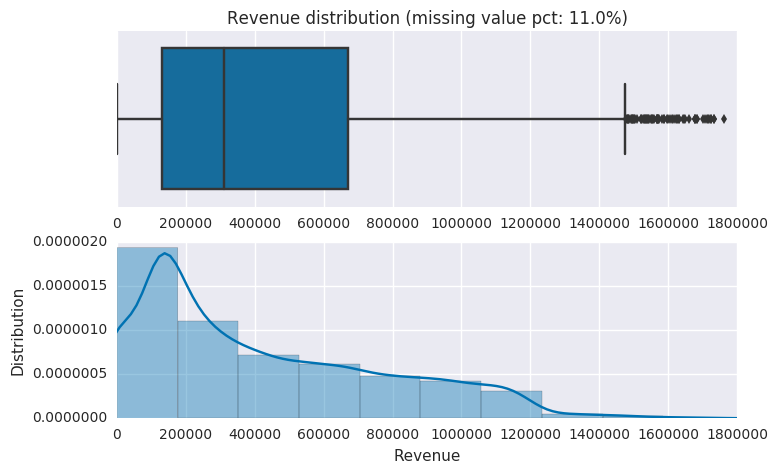

In [40]:
#find percent missing values
perc_missing = 100.*revenue[revenue['revenue']==0].groupby('revenue').size()[0]/len(revenue.index)

#plot
hist = plt.figure(figsize=(8,5))
ax=hist.add_subplot(2,1,1)
sns.boxplot(revenue['revenue'])
plt.title('Revenue distribution (missing value pct: {:.1f}%)'.format(perc_missing), fontsize=12)
plt.xlabel('')
xmin,xmax = ax.get_xlim()

ax=hist.add_subplot(2,1,2)
sns.distplot(revenue['revenue'],bins=10)
plt.xlabel('Revenue')
plt.ylabel('Distribution')
plt.xlim(xmin,xmax)

plt.show()

### Note:

There **do not seem to be any extreme outliers**, though it might be a good idea to remove businesses with **$0 revenue** when measuring the relationship between business revenue and response rate.

<a id='email_dataset'></a>
## Email Dataset for Unique Businesses

In [41]:
emails_input = pd.read_csv('emails.csv')

In [42]:
emails_input.head()

,id,month,message,responded
0,0,2,Text,False
1,0,8,Text,False
2,0,9,Interactive,False
3,0,11,Interactive,False
4,4,0,Text,False


In [43]:
emails = pd.merge(emails_input, bus_ref[['unique_id','id']], how='inner', on='id')

In [44]:
pd.crosstab(index=emails['responded'], columns=emails['message'], margins=True)

message,Interactive,Text,All
responded,,,
False,43443,74821,118264
True,3585,6297,9882
All,47028,81118,128146


In [45]:
tot_summary = pd.crosstab(index=emails['responded'],columns=emails['message'],margins=True)

tot_summary/tot_summary.ix['All',]

message,Interactive,Text,All
responded,,,
False,0.923769,0.922372,0.922885
True,0.076231,0.077628,0.077115
All,1.000000,1.000000,1.000000


### Note:
Overall response rate for **both Interactive and text-based emails are around 7.7%** (higher than I would have guessed). It is interesting that, as a whole, the interactive email does not seem to drive higher response rate, but there may be differences once we begin to segment by month or revenue.

In [46]:
tot_sent = emails[(emails['responded']==True)].groupby(['message','month'],as_index=False)['id'].count()

<a id= 'messages_by_month'></a>
## Analysis of Messages by Month: Interactive vs. Text

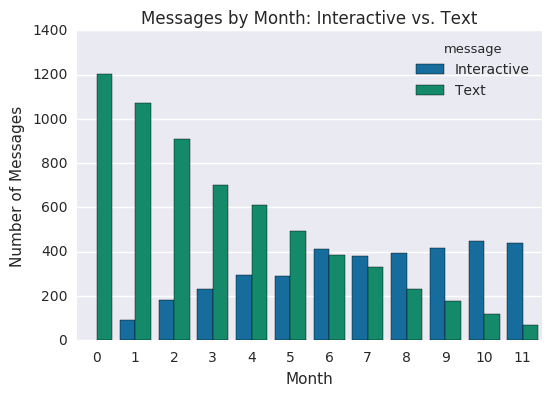

In [47]:
sns.barplot(data=tot_sent,x='month', y='id', hue='message')
plt.title('Messages by Month: Interactive vs. Text')
plt.ylabel('Number of Messages')
plt.xlabel('Month')
plt.show()

The number of Text messages have drop significantly as Interactive messages become more prevalent.  

---


In [48]:
rate_month = \
    emails[(emails['responded']==True)].groupby(['message','month'])['id'].count()/ \
    emails[(emails['responded']==False)].groupby(['message','month'])['id'].count() \

rate_month = rate_month.to_frame()

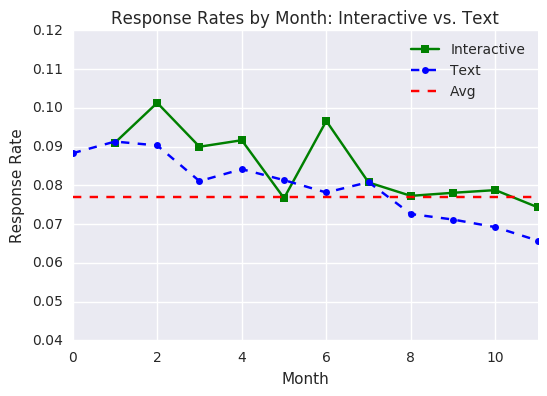

In [49]:
inter_line = plt.plot(rate_month[rate_month.index.get_level_values('message')=='Interactive'].index.get_level_values('month'),
    rate_month[rate_month.index.get_level_values('message')=='Interactive']['id'],
    linestyle='-',marker='s',markersize=6,color='green',label='Interactive')

text_line = plt.plot(rate_month[rate_month.index.get_level_values('message')=='Text'].index.get_level_values('month'),
    rate_month[rate_month.index.get_level_values('message')=='Text']['id'],
    linestyle='--',marker='o',markersize=5,color='blue',label='Text')

avg_line = plt.plot(range(0,12),[0.077]*12,linestyle='--',color='red',label='Avg')

plt.title('Response Rates by Month: Interactive vs. Text', fontsize=12)
plt.xlabel('Month')
plt.ylabel('Response Rate')
plt.ylim(0.04,0.12)
plt.xlim(0,11)

plt.legend()
plt.show()

### Note:
When looking at response rate over time, it appears that there is a **slight negative trend**. It is interesting that this trend is relatively consistent despite the drastic change in message distribution (interactive vs. text).  

It is also interesting to note that the **interactive response rate does seem slightly higher in all but month 5**, despite having a lower overall response rate **(Simson's Paradox)**.

<a id='revenue'></a>
## Revenue vs. Response Rates

In [50]:
temp = emails[['unique_id','responded']].groupby('unique_id').count()
temp.describe()

,responded
count,19987.000000
mean,6.411467
std,3.897453
min,1.000000
25%,3.000000
50%,6.000000
75%,9.000000
max,24.000000


In [51]:
bus_emails = emails[['unique_id','message','responded','id']] \
    .groupby(['unique_id','message','responded']) \
    .count()

In [52]:
bus_emails = bus_emails.unstack().unstack().fillna(value=0)

In [53]:
bus_emails.head()

id                      
responded       False            True      
message   Interactive Text Interactive Text
unique_id                                  
1                 5.0  4.0         0.0  0.0
2                 1.0  2.0         1.0  0.0
3                 1.0  1.0         0.0  1.0
4                 0.0  0.0         0.0  1.0
5                 8.0  5.0         0.0  0.0

In [54]:
revenue.index = revenue['unique_id']

In [55]:
bus_emails = pd.merge(bus_emails, revenue, how='inner', left_index=True, right_index=True)
bus_emails.columns = ['interactive_false','text_false','interactive_true','text_true','unique_id','revenue']
bus_emails.drop('unique_id',axis=1,inplace=True)

In [56]:
bus_emails.head()

,interactive_false,text_false,interactive_true,text_true,revenue
unique_id,,,,,
1,5.0,4.0,0.0,0.0,925944.0
2,1.0,2.0,1.0,0.0,203226.0
3,1.0,1.0,0.0,1.0,147764.0
4,0.0,0.0,0.0,1.0,360617.0
5,8.0,5.0,0.0,0.0,465957.0


In [57]:
bus_emails['rev_bin'] = pd.cut(bus_emails['revenue'],50)

In [58]:
bus_emails.head()

,interactive_false,text_false,interactive_true,text_true,revenue,rev_bin
unique_id,,,,,,
1,5.0,4.0,0.0,0.0,925944.0,"(916183.84, 951421.68]"
2,1.0,2.0,1.0,0.0,203226.0,"(176189.2, 211427.04]"
3,1.0,1.0,0.0,1.0,147764.0,"(140951.36, 176189.2]"
4,0.0,0.0,0.0,1.0,360617.0,"(352378.4, 387616.24]"
5,8.0,5.0,0.0,0.0,465957.0,"(458091.92, 493329.76]"


In [59]:
bus_emails['interactive_rate'] = bus_emails['interactive_true']/(bus_emails['interactive_true']+bus_emails['interactive_false'])
bus_emails['text_rate'] = bus_emails['text_true']/(bus_emails['text_true']+bus_emails['text_false'])

In [60]:
rev_bin_response = bus_emails.groupby('rev_bin').sum()
rev_bin_response['interactive_rate'] = rev_bin_response['interactive_true']/(rev_bin_response['interactive_true']+rev_bin_response['interactive_false'])
rev_bin_response['text_rate'] = rev_bin_response['text_true']/(rev_bin_response['text_true']+rev_bin_response['text_false'])

In [61]:
rev_bin_response

,interactive_false,text_false,interactive_true,text_true,revenue,interactive_rate,text_rate
rev_bin,,,,,,,
"(-1761.892, 35237.84]",4519.0,7383.0,360.0,627.0,0.0,0.073786,0.078277
"(35237.84, 70475.68]",228.0,424.0,21.0,40.0,5711514.0,0.084337,0.086207
"(70475.68, 105713.52]",2417.0,4364.0,231.0,441.0,120889815.0,0.087236,0.091779
"(105713.52, 140951.36]",3803.0,6818.0,350.0,694.0,236378359.0,0.084276,0.092386
"(140951.36, 176189.2]",2730.0,5050.0,270.0,479.0,215427259.0,0.090000,0.086634
"(176189.2, 211427.04]",2053.0,3554.0,196.0,377.0,193397752.0,0.087150,0.095904
"(211427.04, 246664.88]",1691.0,2983.0,174.0,306.0,190877656.0,0.093298,0.093037
"(246664.88, 281902.72]",1464.0,2694.0,156.0,298.0,200834164.0,0.096296,0.099599
"(281902.72, 317140.56]",1331.0,2353.0,144.0,251.0,201398653.0,0.097627,0.096390


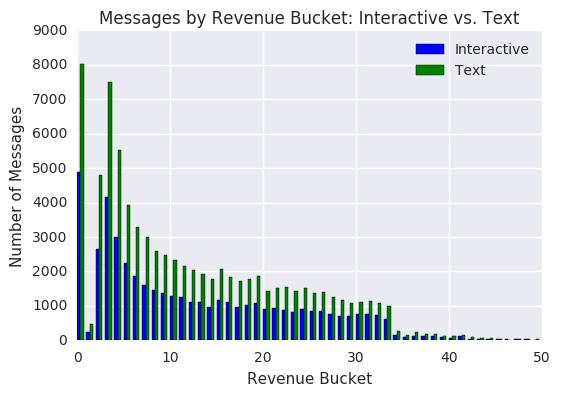

In [62]:
N = 50
ind = np.arange(N)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind, rev_bin_response['interactive_false']+rev_bin_response['interactive_true'], width, color='blue', label='Interactive')
rects2 = ax.bar(ind + width, rev_bin_response['text_false']+rev_bin_response['text_true'], width, color='green', label='Text')

plt.title('Messages by Revenue Bucket: Interactive vs. Text', fontsize=12)
plt.xlabel('Revenue Bucket')
plt.ylabel('Number of Messages')
#plt.ylim(0.04,0.12)

plt.legend()
plt.show()

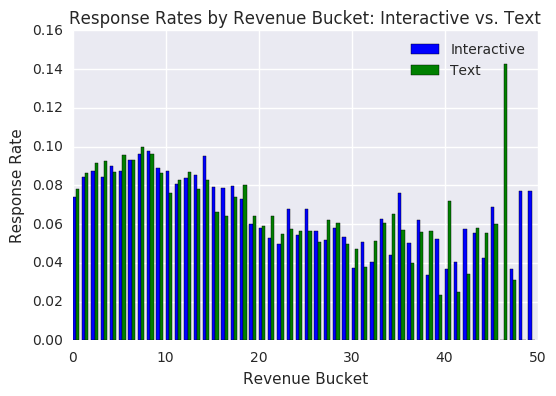

In [63]:
N = 50
ind = np.arange(N)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind, rev_bin_response['interactive_rate'], width, color='blue', label='Interactive')
rects2 = ax.bar(ind + width, rev_bin_response['text_rate'], width, color='green', label='Text')

plt.title('Response Rates by Revenue Bucket: Interactive vs. Text', fontsize=12)
plt.xlabel('Revenue Bucket')
plt.ylabel('Response Rate')

plt.legend()
plt.show()

In [64]:
rev_bin_response['rev_bin_id'] = range(0,50)

In [65]:
from scipy import stats
def r2(x,y):
    return stats.pearsonr(x,y)[0]**2

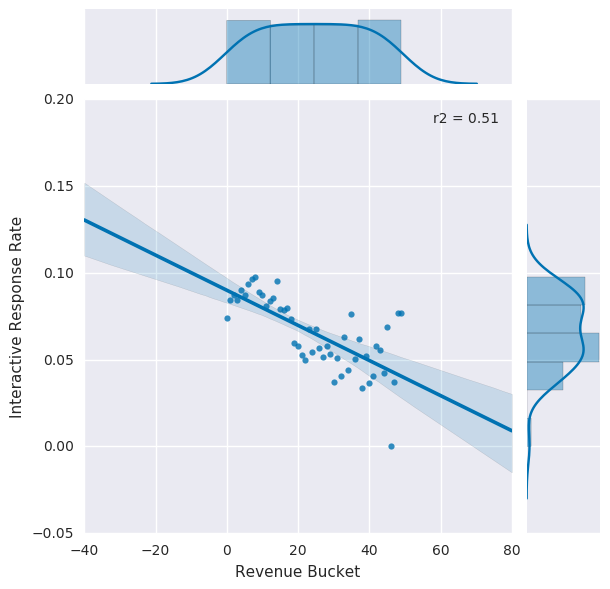

In [66]:
sns.jointplot(data=rev_bin_response,x='rev_bin_id',y='interactive_rate',kind='reg',stat_func=r2)
plt.xlabel('Revenue Bucket')
plt.ylabel('Interactive Response Rate')
plt.show()

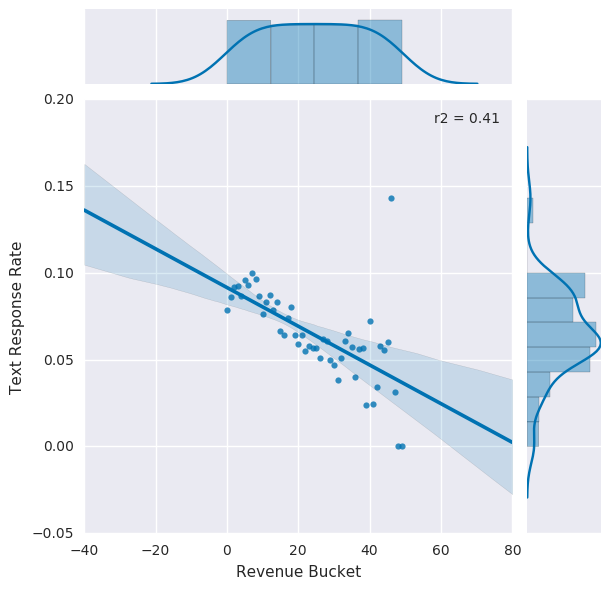

In [67]:
sns.jointplot(data=rev_bin_response,x='rev_bin_id',y='text_rate',kind='reg',stat_func=r2)
plt.xlabel('Revenue Bucket')
plt.ylabel('Text Response Rate')
plt.show()

<a id='methodology'></a>
## Methodology and Takeaways

The reasoning behind bucketing revenue is because each business had on average 6 total messages throughout the 12 months - this would cause the response rates to be very non-continuous in distribution.  

By bucketing revenue, it is possible to get a large sample size of messages. Based on the bar chart above, it appears that **response rate decreases substantially as revenue increases** (excluding what appears to be buckets with lower sample near the very high end).  

Like the breakdown by month, it appears that **Interactive messages do not provide noticeable increases in response rates**.

<a id='conclusion'></a>
# Conclusion / Next Steps:
Although it appears that Interactive and Text messages have similar response rates across months and across revenue buckets, there are a few additional pieces of analysis that would be interesting.

With additional time, I would look into the **"compounding effect" of multiple messages sent to the same business (both Interactive & Text)**. Similarly, with some additional cleaning of the postal code info, it would be interesting to see if there is a geographical impact on response rates.   

Lastly, although it would take additional data, I would like to understand if there is a difference between Interactive & Text messages in terms of loyalty/retention over time.  

